In [10]:
from janome.tokenizer import Tokenizer
import os
import numpy as np
import pandas as pd
import unicodedata
from pathlib import Path
import json
import re
import unicodedata
import string
import MeCab
import oseti
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from pyknp import Juman

from janome.tokenizer import Tokenizer
from gensim.models import word2vec

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv('/Users/nagasawanaokazu/Desktop/卒業成果物/twitter_data.csv')
df = df.drop('Unnamed: 0',axis=1)

In [3]:
#形態素解析（MeCab）

In [4]:
df.head()

,投稿日時,投稿本文,Label,リツイート,いいね数,名前,フォロワー,フォロー,投稿数
0,Mon Mar 15 14:30:26 +0000 2021,@Carboon39 コロナで上がった分どこかで下がるのでは？という不安は拭えないです\nし...,-1,0,0,たっちゃん,116,189,3981
1,Mon Mar 15 14:25:05 +0000 2021,保有銘柄は\n\neMAXIS Slim 全世界株式\neMAXIS Slim S&amp;...,0,0,0,しろくま,33,106,177
2,Mon Mar 15 13:06:21 +0000 2021,@haru_tachibana8 つみたてNISA対象の有名なインデックス・ファンドは、どれ...,0,0,4,マメ助@家庭菜園×資産運用に役立つ記事を配信中,1701,4823,406
3,Mon Mar 15 12:19:28 +0000 2021,私が買ってる投資信託は運用手数料が低いインデックスファンドを選んでます。\n\n•eMAXI...,0,0,2,ゆっこ@26歳投資家,41,48,44
4,Mon Mar 15 08:40:46 +0000 2021,今は、アクティブファンドより\nインデックスファンドの時代。\n\n個人的には日本株よりは米...,1,0,1,J,29,0,1732


In [5]:
import unicodedata
import string

def format_text(text):
    text = unicodedata.normalize("NFKC", text)  # 全角記号をざっくり半角へ置換（でも不完全）

    # 記号を消し去るための魔法のテーブル作成
    table = str.maketrans("", "", string.punctuation  + "「」、。・//\\＼＼\n")
    text = text.translate(table)

    return text

In [6]:
df['投稿本文'] = df['投稿本文'].apply(format_text)

In [9]:
stop_words = [
    'Lagarde','speaks','about','an','hour', 'If', 'can','confirm', 'dovish', 'bias',
    'which','think','it','take','amp','TicTocTick','suspic','gotonikkei','SampP',
    'he','will','in','ECB','あれ','','hirox','する','こと','てる','10','30','15','そこ','ところ',
    "その", "ため",'いる','てる','050','500','2021','the','for','pt','de','la','Ads','by',
    'PH','only','Metal','over','on','JustforMew','avez','LS','23','rotation','httpstco',
    '027','Long','at','sp','バン','Slim','SBI','SP','20','47','RT','sp','よう','VTI','91',
    '12','00','33333','NCDWXIWfmr'
]

In [10]:
def stop_words_df(sentence):
    for s in stop_words:
        sentence = sentence.replace(s, '')
    return sentence

In [11]:
df['投稿本文'] = df['投稿本文'].apply(stop_words_df)

In [12]:
def Mplg(text):
    output_words = []
    #辞書へのパス
    m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/ipadic')
    soup = m.parse (text)
    for row in soup.split("\n"):
        word =row.split("\t")[0]
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]
            slice = pos.split(",")
            if len(word) > 1:
                if slice[0] == '名詞' :
                    output_words.append(word)
                elif slice[0] in [ "形容詞" , "動詞", "副詞"]:
                    if slice[5] == "基本形":
                        output_words.append(slice[-3])#活用していない原型を取得
    return ' '.join(output_words)

In [13]:
df['mecab_text'] = df['投稿本文'].apply(Mplg)

In [14]:
#polarity付与

In [15]:
df['mecab_text'][0]

'Carbo 39 コロナ どこ 下がる 不安 世界中 人達 年金 積み立て ファンド 暴落 もの 先日 ハイ グロ 暴落 イン'

In [17]:
analyzer = oseti.Analyzer()

In [18]:
analyzer.analyze(df['mecab_text'][0])

[-0.6]

In [19]:
polarity = []

for node in df['mecab_text']:
    analyzer = oseti.Analyzer()
    a = analyzer.analyze(node)
    polarity.append(sum(a)/len(a))

In [20]:
len(polarity)

100

In [38]:
df['polarity'] = polarity

In [22]:
#少数点削除
df['polarity'] = df['polarity'].round().astype(int)

In [23]:
df.loc[df['Label'] >= 0,'Label'] = 1
df.loc[df['polarity'] >= 0,'polarity'] = 1

In [24]:
df.head(3)

,投稿日時,投稿本文,Label,リツイート,いいね数,名前,フォロワー,フォロー,投稿数,mecab_text,polarity
0,Mon Mar 15 14:30:26 +0000 2021,Carbo39 コロナで上がった分どこかで下がるのではという不安は拭えないですしかし世界中の...,-1,0,0,たっちゃん,116,189,3981,Carbo 39 コロナ どこ 下がる 不安 世界中 人達 年金 積み立て ファンド 暴落 ...,-1
1,Mon Mar 15 14:25:05 +0000 2021,保有銘柄はeMAXIS 全世界株式eMAXIS 楽天ニッセイ外国株式インデックスファンド...,1,0,0,しろくま,33,106,177,保有 銘柄 eMAXIS 世界 株式 eMAXIS 楽天 ニッセイ 外国 株式 インデックス...,1
2,Mon Mar 15 13:06:21 +0000 2021,harutachiba8 つみたてNISA対象の有名なインデックスファンドはどれも分配金0円...,1,0,4,マメ助@家庭菜園×資産運用に役立つ記事を配信中,1701,4823,406,harutachiba NISA 対象 有名 インデックス ファンド どれ 分配 eMAXI...,1


In [25]:
text = df['mecab_text']

In [26]:
p = df['Label']
w = df['polarity']

In [27]:
print('AUC in validation data: ', roc_auc_score(p, w))

AUC in validation data:  0.6041666666666667


In [140]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [809]:
confusion_matrix(p, w)

array([[ 1,  3],
       [ 4, 92]])

In [810]:
accuracy = accuracy_score(p,w)
print('正解率:',accuracy)

正解率: 0.93


In [811]:
recall = recall_score(p,w)
print('検出率:',recall)

検出率: 0.9583333333333334


In [814]:
f1_score = f1_score(p,w)
print('f1_score:',f1_score)

f1_score: 0.9633507853403142


In [506]:
a = df['polarity'].mean()
a = round(a,3)
a

0.232

/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


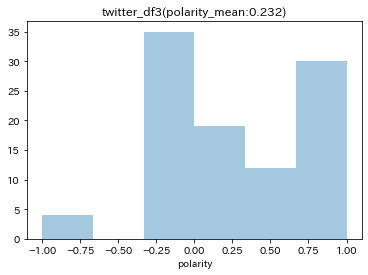

In [507]:
line_plot = sns.lineplot()
figure = line_plot.get_figure()

plt.title('twitter_df3'+'('+'polarity_mean:'+str(a)+')',loc='center')
sns.distplot(df['polarity'],kde=False)

figure.savefig('Desktop/df3_sns.pdf')

In [39]:
posi = []
litle_posi = []
litle_nega = []
nega = []
neutral = []

def count(df):
    for node in df:
        if -1.0 <= node <= -0.5:
            nega.append(node)
        elif -0.5 < node < 0:
            litle_nega.append(node)
        elif 0 < node < 0.5:
            litle_posi.append(node)
        elif 0.5 <= node <= 1.0 :
            posi.append(node)
        else:
            neutral.append(node)

In [40]:
count(df['polarity'])

In [36]:
import japanize_matplotlib

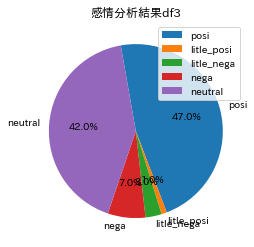

In [41]:
aa = len(posi)
bb = len(litle_posi)
cc = len(litle_nega)
dd = len(nega)
ee = len(neutral)
    
x = [aa,bb,cc,dd,ee]
label = ['posi','litle_posi','litle_nega','nega','neutral']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
    
plt.pie(x, labels=label, counterclock=False, startangle=100, autopct="%1.1f%%",pctdistance=0.6)

# legend and title
ax.legend(loc='best')
ax.set_title('感情分析結果df3')

fig.savefig("Desktop/df3_d.pdf")

In [377]:
print(aa+bb+cc+dd+ee)

100


In [511]:
r = df['mecab_text'][2]
r = analyzer.analyze_detail(r)
r

[{'positive': ['儲かる', '資産'], 'negative': ['貧乏人', '詐欺', '貧乏人'], 'score': -0.2}]

In [512]:
code = []

for i in df['mecab_text']:
    c = analyzer.analyze_detail(i)
    code.append(c)

In [514]:
with open('Desktop/code_3.txt', 'a') as f:
    print(code, file=f)

In [450]:
df.head(1)

,投稿日時,投稿本文,Label,リツイート,いいね数,名前,フォロワー,フォロー,投稿数,mecab_text,polarity
0,Mon Mar 15 14:30:26 +0000 2021,Carbo39 コロナで上がった分どこかで下がるのではという不安は拭えないですしかし世界中の...,-1,0,0,たっちゃん,116,189,3981,Carbo 39 コロナ どこ 下がる 不安 世界中 人達 年金 積み立て ファンド 暴落 ...,-1


In [451]:
text = df['mecab_text']

In [452]:
#重複したワードを削除
word = []
    
for col in text:
    u = []
    for run in col.split(' '):
        if run not in u:
            u.append(run)
    word.append(u)

In [453]:
words = []

for col in word:
    a = ' '.join(col)
    words.append(a)

In [454]:
df['stop_word'] = words

In [455]:
polarity = []

for node in df['stop_word']:
    analyzer = oseti.Analyzer()
    a = analyzer.analyze(node)
    polarity.append(sum(a)/len(a))

In [456]:
analyzer.analyze(df['stop_word'][0])

[-0.3333333333333333]

In [457]:
df['stop_polarity'] = polarity

In [391]:
df.loc[df['stop_polarity'] >= 0,'stop_polarity'] = 1
df.loc[df['stop_polarity'] <= 0,'stop_polarity'] = -1

In [393]:
#少数点削除
df['stop_polarity'] = df['stop_polarity'].round().astype(int)

In [394]:
df.head(2)

,投稿日時,投稿本文,Label,リツイート,いいね数,名前,フォロワー,フォロー,投稿数,mecab_text,polarity,stop_word,stop_polarity
0,Mon Mar 15 14:30:26 +0000 2021,Carbo39 コロナで上がった分どこかで下がるのではという不安は拭えないですしかし世界中の...,-1,0,0,たっちゃん,116,189,3981,Carbo 39 コロナ どこ 下がる 不安 世界中 人達 年金 積み立て ファンド 暴落 ...,-1,Carbo 39 コロナ どこ 下がる 不安 世界中 人達 年金 積み立て ファンド 暴落 ...,-1
1,Mon Mar 15 14:25:05 +0000 2021,保有銘柄はeMAXIS 全世界株式eMAXIS 楽天ニッセイ外国株式インデックスファンド...,1,0,0,しろくま,33,106,177,保有 銘柄 eMAXIS 世界 株式 eMAXIS 楽天 ニッセイ 外国 株式 インデックス...,1,保有 銘柄 eMAXIS 世界 株式 楽天 ニッセイ 外国 インデックス ファンド オルカン...,1


In [395]:
p = df['Label']
w = df['stop_polarity']

In [396]:
print('AUC in validation data: ', roc_auc_score(p, w))

AUC in validation data:  0.5729166666666667


In [458]:
r = df['stop_word'][67]
r = analyzer.analyze_detail(r)
r

[{'positive': [], 'negative': ['高値'], 'score': -1.0}]

In [460]:
dict_word = []

for i in df['stop_word']:
    w = analyzer.analyze_detail(i)
    dict_word.append(w)

In [461]:
for line in dict_word[:5]:
    print(line)
    print('*******************************************')

[{'positive': ['年金'], 'negative': ['不安', '暴落'], 'score': -0.3333333333333333}]
*******************************************
[{'positive': [], 'negative': [], 'score': 0.0}]
*******************************************
[{'positive': ['有名'], 'negative': [], 'score': 1.0}]
*******************************************
[{'positive': [], 'negative': ['手数料'], 'score': -1.0}]
*******************************************
[{'positive': ['おすすめ'], 'negative': [], 'score': 1.0}]
*******************************************


In [470]:
for (line,lin) in zip(t_1[:5],dict_word[:5]):
    print(line)
    print('---------------------（　処理前　）----------------------------')
    print(lin)
    print('*******************************************')

Carbo39 コロナで上がった分どこかで下がるのではという不安は拭えないですしかし世界中の人達が年金積み立てやファンドがそんなに暴落ものかとも私は先日ハイグロ暴落時にド底で売ってしまったのでイン NCDWXIWfmr
---------------------（　処理前　）----------------------------
[{'positive': ['年金'], 'negative': ['不安', '暴落'], 'score': -0.3333333333333333}]
*******************************************
保有銘柄はeMAXIS  全世界株式eMAXIS  楽天ニッセイ外国株式インデックスファンドいろいろ悩んで今はオルカンに上限いっぱいまで
---------------------（　処理前　）----------------------------
[{'positive': [], 'negative': [], 'score': 0.0}]
*******************************************
harutachiba8 つみたてNISA対象の有名なインデックスファンドはどれも分配金0円ですね☺eMAXIS オルカン楽天VT楽天 雪だるま全世界など
---------------------（　処理前　）----------------------------
[{'positive': ['有名'], 'negative': [], 'score': 1.0}]
*******************************************
私が買っ投資信託は運用手数料が低いインデックスファンドを選んでます•eMAXIS  米国株式 運用手数料968•eMAXIS  全世界株式運用手数料01144アク JaAd4uJjlV
---------------------（　処理前　）----------------------------
[{'positive': [], 'negative': ['手数料'], 'score': -1.0}]
*******************************************
今はアクティブファン

In [445]:
t_1 = df['投稿本文']

In [446]:
for line in t_1[:5]:
    print(line)
    print('*******************************************')

Carbo39 コロナで上がった分どこかで下がるのではという不安は拭えないですしかし世界中の人達が年金積み立てやファンドがそんなに暴落ものかとも私は先日ハイグロ暴落時にド底で売ってしまったのでイン NCDWXIWfmr
*******************************************
保有銘柄はeMAXIS  全世界株式eMAXIS  楽天ニッセイ外国株式インデックスファンドいろいろ悩んで今はオルカンに上限いっぱいまで
*******************************************
harutachiba8 つみたてNISA対象の有名なインデックスファンドはどれも分配金0円ですね☺eMAXIS オルカン楽天VT楽天 雪だるま全世界など
*******************************************
私が買っ投資信託は運用手数料が低いインデックスファンドを選んでます•eMAXIS  米国株式 運用手数料968•eMAXIS  全世界株式運用手数料01144アク JaAd4uJjlV
*******************************************
今はアクティブファンドよりインデックスファンドの時代個人的には日本株よりは米国株がおすすめですで長期投資を
*******************************************


### ネガポジ

In [411]:
df = pd.read_csv('/Users/nagasawanaokazu/Desktop/卒業成果物/twitter_df1.csv')
df_1 = df.drop('Unnamed: 0',axis=1)

In [312]:
pd.get_option("display.max_columns",100)
pd.set_option('display.max_rows', 100)

In [313]:
#df_1
#df_2
#df_3

In [314]:
import MeCab

In [315]:
#重複した行の確認
print(df_3.duplicated().sum())

NameError: name 'df_3' is not defined

In [9]:
import unicodedata
import string

def format_text(text):
    text = unicodedata.normalize("NFKC", text)  # 全角記号をざっくり半角へ置換（でも不完全）

    # 記号を消し去るための魔法のテーブル作成
    table = str.maketrans("", "", string.punctuation  + "「」、。・//\\＼＼\n")
    text = text.translate(table)

    return text

In [412]:
df_1['投稿本文'] = df_1['投稿本文'].apply(format_text)
#df_2['投稿本文'] = df_2['投稿本文'].apply(format_text)
#df_3['投稿本文'] = df_3['投稿本文'].apply(format_text)

In [317]:
stop_words = [
    'Lagarde','speaks','about','an','hour', 'If', 'can','confirm', 'dovish', 'bias',
    'which','think','it','take','amp','TicTocTick','suspic','gotonikkei','SampP',
    'he','will','in','ECB','あれ','','hirox','する','こと','てる','10','30','15','そこ','ところ',
    "その", "ため",'いる','てる','050','500','2021','the','for','pt','de','la','Ads','by',
    'PH','only','Metal','over','on','JustforMew','avez','LS','23','rotation','httpstco',
    '027','Long','at','sp','バン','Slim','SBI','SP','20','47','RT','sp','よう','VTI','91',
    '12','00','33333'
]

In [318]:
def stop_words_df(sentence):
    for s in stop_words:
        sentence = sentence.replace(s, '')
    return sentence

In [413]:
df_1['投稿本文'] = df_1['投稿本文'].apply(stop_words_df)
#df_2['投稿本文'] = df_2['投稿本文'].apply(stop_words_df)
#df_3['投稿本文'] = df_3['投稿本文'].apply(stop_words_df)

In [ ]:
#辞書の保存先確認
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

In [320]:
def Mecab(text):
    output_words = []
    #辞書へのパス
    m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/ipadic')
    soup = m.parse (text)
    for row in soup.split("\n"):
        word =row.split("\t")[0]
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]
            slice = pos.split(",")
            if len(word) > 1:
                if slice[0] == '名詞' :
                    output_words.append(word)
                elif slice[0] in [ "形容詞" , "動詞", "副詞"]:
                    if slice[5] == "基本形":
                        output_words.append(slice[-3])#活用していない原型を取得
    return  output_words

In [414]:
df_1['mecab_text'] = df_1['投稿本文'].apply(Mecab)
#df_2['mecab_text'] = df_2['投稿本文'].apply(Mecab)
#df_3['mecab_text'] = df_3['投稿本文'].apply(Mecab)

In [415]:
text_1 = df_1['mecab_text']
#text_2 = df_2['mecab_text']
#text_3 = df_3['mecab_text']

In [323]:
from collections import Counter
# 集計 ※dict型を定義してgetメソッドで数える。
import collections

words = {}

for w in text_1:
    for word in w:
        words[word] = words.get(word, 0) + 1

In [324]:
#上位10件
mycounter = Counter(words)
for word in mycounter.most_common(10):
    print(word)

('ファンド', 111)
('インデックス', 103)
('株式', 89)
('投資', 71)
('米国', 51)
('楽天', 42)
('eMAXIS', 37)
('世界', 31)
('NISA', 26)
('積立', 21)


In [416]:
posi_nega_score('neo')

0.171900478590812

In [95]:
keyword = [
    '上昇','増加','増収','増益','上り','利益','+','プラス','損益','黒字','増える','増えた',
    '大きい','下降','減少','減収','減益','下り','負債','借金','マイナス','-','低下','減り',
    '減る','少ない','破産','破綻','廃業','暴落','下がる','不安','上がった','不安','選んでいる',
    '選んでいる','良い','おすすめ'
]

In [30]:
import gensim
#fasttextのモデルを読み込む
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/nagasawanaokazu/Desktop/model.vec', binary=False)

#「非常にポジティブな単語」と「非常にネガティブな単語」を任意で指定
posi_list = [
    '上昇','増加','増収','増益','上り','利益','+','プラス','損益','黒字','増える',
    '増えた','大きい','良い','おすすめ','上がった'
]
nega_list = [
    '下降','減少','減収','減益','下り','負債','借金','マイナス','-','低下','減り','減る',
    '少ない','破産','破綻','廃業','減る','少ない','破産','破綻','廃業','暴落','下がる',
    '不安','不安','選んでいる',
]

def posi_nega_score(x):
    #ポジティブ度合いの判定
    posi = []
    for i in posi_list:
        try:
            n = model.similarity(i, x)
            posi.append(n)
        except:
            continue
    try:
        posi_mean = sum(posi)/len(posi)
    except:
        posi_mean = 0

    #ネガティブ度合いの判定
    nega = []
    for i in nega_list:
        try:
            n = model.similarity(i, x)
            nega.append(n)
        except:
            continue
    try:
        nega_mean = sum(nega)/len(nega)
    except:
        nega_mean = 0
    if posi_mean > nega_mean:
        return posi_mean
    if nega_mean > posi_mean:
        return -nega_mean
    else:
        return 0

Exception ignored in: <bound method tqdm.__del__ of Downloading:   0%|          | 0.00/1.32k [12:21<?, ?B/s]>
Traceback (most recent call last):
  File "/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/site-packages/tqdm/std.py", line 1134, in __del__
    self.close()
  File "/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/site-packages/tqdm/notebook.py", line 280, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'disp'


In [ ]:
#ネガポジ付与

In [417]:
score = []
    
for texts in text_1:
    count = 0
    nega = []
    posi = []
    
    for node in texts:
        if posi_nega_score(node) < -0.2:
            nega.append(posi_nega_score(node))
            count += 1
        elif posi_nega_score(node) > 0.2:
            posi.append(posi_nega_score(node))
            count += 1
    s = sum(nega)+sum(posi)/count
    score.append(s)

In [418]:
df['polarity'] = score

In [422]:
df

,Unnamed: 0,投稿日時,投稿本文,リツイート,いいね数,名前,フォロワー,フォロー,投稿数,polarity
0,0,Mon Mar 15 14:30:26 +0000 2021,@Carboon39 コロナで上がった分どこかで下がるのでは？という不安は拭えないです\nし...,0,0,たっちゃん,116,189,3981,-0.813285
1,1,Mon Mar 15 14:25:05 +0000 2021,保有銘柄は\n\neMAXIS Slim 全世界株式\neMAXIS Slim S&amp;...,0,0,しろくま,33,106,177,0.197370
2,2,Mon Mar 15 13:06:21 +0000 2021,@haru_tachibana8 つみたてNISA対象の有名なインデックス・ファンドは、どれ...,0,4,マメ助@家庭菜園×資産運用に役立つ記事を配信中,1701,4823,406,0.939364
3,3,Mon Mar 15 12:19:28 +0000 2021,私が買ってる投資信託は運用手数料が低いインデックスファンドを選んでます。\n\n•eMAXI...,0,2,ゆっこ@26歳投資家,41,48,44,0.293026
4,4,Mon Mar 15 08:40:46 +0000 2021,今は、アクティブファンドより\nインデックスファンドの時代。\n\n個人的には日本株よりは米...,0,1,J,29,0,1732,0.959187
5,5,Mon Mar 15 01:46:01 +0000 2021,3/12 逆日歩日数 1日\n\n1547 上場インデックスファンド米国株式(S&amp;P...,0,0,逆日歩速報,4731,1,94360,-0.452429
6,6,Mon Mar 15 01:18:21 +0000 2021,@ahokusoburg s&amp;p500とfang +とiDeCoと個人年金に全振りで...,0,0,プププ（BON.G美淋）,28,53,275,0.939364
7,7,Sun Mar 14 21:10:16 +0000 2021,今は、アクティブファンドより\nインデックスファンドの時代。\n\n個人的には日本株よりは米...,0,1,J,29,0,1732,0.959187
8,8,Sun Mar 14 12:15:44 +0000 2021,昨年の秋から初めたつみたてNISA（SBIバンガードS＆P500インデックスファンド）が良い...,0,1,ななし,1,78,6,0.675589
9,9,Sun Mar 14 11:18:41 +0000 2021,たまに、このような例えばS&amp;P500連動型のインデックスファンドに投資を長年して資産...,0,5,社畜りーまん@投資初心者の味方,836,532,1539,-0.153844


In [421]:
#与えられたpolarityを-1から1の範囲に調整
sco = np.array(df['polarity'])
sco_std = (sco - sco.min())/(sco.max() - sco.min())
sco_scaled = sco_std * (1 - (-1)) + (-1)
df['polarity'] = sco_scaled

In [419]:
posi = []
litle_posi = []
litle_nega = []
nega = []
neutral = []

for l in df['polarity']:
    if 0.5 <= l <= 1:
        posi.append(l)
    elif 0 < l < 0.5:
        litle_posi.append(l)
    elif -0.5 <= l < 0:
        litle_nega.append(l)
    elif -1 <= l < -0.5:
        nega.append(l)
    else:
        neutral.append(l)

In [ ]:
aa = len(posi)
bb = len(litle_posi)
cc = len(litle_nega)
dd = len(nega)
ee = len(neutral)
    
x = [aa,bb,cc,dd,ee]
label = ['poji','litle_poji','litle_nega','nega','neutral']
    
plt.pie(x, labels=label, counterclock=False, startangle=180, autopct="%1.1f%%",pctdistance=0.7)

In [ ]:
print(aa+bb+cc+dd+ee)

In [ ]:
#フラグ

In [423]:
flag = []

for texts in text_1:
    count = 0
    nega = 0
    posi = 0
    neutral = 0
    for node in texts:
        if posi_nega_score(node) < -0.2:
            count += 1
            nega += -1
        elif posi_nega_score(node) > 0.2:
            count += 1
            posi += 1
    s = nega+posi/count
    flag.append(s)

In [424]:
len(flag)

100

In [425]:
df_1['フラグ'] = flag

In [428]:
#与えられたフラグを-1から1の範囲に調整
sco = np.array(df_1['フラグ'])
sco_std = (sco - sco.min())/(sco.max() - sco.min())
sco_scaled = sco_std * (1 - (-1)) + (-1)
df_1['flag_スコア'] = sco_scaled

In [267]:
posi = []
litle_posi = []
litle_nega = []
nega = []
neutral = []

for l in df_3['flag_スコア']:
    if 0.5 <= l <= 1:
        posi.append(l)
    elif 0 < l < 0.5:
        litle_posi.append(l)
    elif -0.5 <= l < 0:
        litle_nega.append(l)
    elif -1 <= l < -0.5:
        nega.append(l)
    else:
        neutral.append(l)

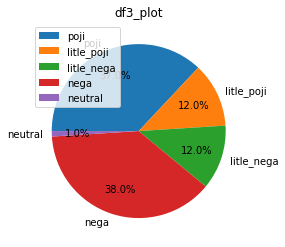

In [268]:
aa = len(posi)
bb = len(litle_posi)
cc = len(litle_nega)
dd = len(nega)
ee = len(neutral)
    
x = [aa,bb,cc,dd,ee]
label = ['poji','litle_poji','litle_nega','nega','neutral']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
    
plt.pie(x, labels=label, counterclock=False, startangle=180, autopct="%1.1f%%",pctdistance=0.7)

# legend and title
ax.legend(loc='best')
ax.set_title('df3_plot')


fig.savefig("Desktop/df3_make.pdf")

In [269]:
print(aa+bb+cc+dd+ee)

100


In [293]:
words = []

for col in word:
    a = ','.join(col)
    words.append(a)

In [295]:
df_1['stop_words'] = word

In [40]:
df = pd.read_csv('/Users/nagasawanaokazu/Desktop/卒業成果物/twitter_data.csv')

In [41]:
df['投稿本文'] = df['投稿本文'].apply(format_text)

In [42]:
df['投稿本文'] = df['投稿本文'].apply(stop_words_df)

In [43]:
df['mecab_text'] = df['投稿本文'].apply(Mecab)

In [62]:
text = df['mecab_text']

In [288]:
def flag_make(text):
    
    flag = []
    
    for texts in text:
        count = 0
        nega = 0
        posi = 0
        neutral = 0
        for node in texts:
            if posi_nega_score(node) < -0.3:
                count += 1
                nega += -1
            elif posi_nega_score(node) > -0.3:
                count += 1
                posi += 1
            else:
                count += 1
                neutral += 0 
                
        s = nega+posi/count
        flag.append(s)
        
    return flag

In [109]:
flag = flag_make(text)

In [111]:
df['polarity'] = flag

In [112]:
df.loc[df['polarity'] > 0 , 'polarity'] = 1
df.loc[df['polarity'] < 0 , 'polarity'] = -1

In [113]:
df.loc[df['Label'] >= 0,'Label'] = 1

In [114]:
#少数点削除
df['polarity'] = df['polarity'].round().astype(int)

In [115]:
p = df['Label']
w = df['polarity']

In [124]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [116]:
print('AUC in validation data: ', roc_auc_score(p, w))

AUC in validation data:  0.6145833333333333


In [118]:
confusion_matrix(p, w)

array([[ 1,  3],
       [ 2, 94]])

In [120]:
accuracy = accuracy_score(w,p)
print('正解率:',accuracy)

正解率: 0.95


In [125]:
recall = recall_score(p,w)
print('検出率:',recall)

検出率: 0.9791666666666666


In [126]:
f1_score = f1_score(p,w)
print('f1_score:',f1_score)

f1_score: 0.9740932642487047


In [55]:
df = pd.read_csv('/Users/nagasawanaokazu/Desktop/卒業成果物/twitter_df1.csv')
df = df.drop('Unnamed: 0',axis=1)

In [56]:
df.head(3)

,投稿日時,投稿本文,リツイート,いいね数,名前,フォロワー,フォロー,投稿数
0,Mon Mar 15 14:30:26 +0000 2021,@Carboon39 コロナで上がった分どこかで下がるのでは？という不安は拭えないです\nし...,0,0,たっちゃん,116,189,3981
1,Mon Mar 15 14:25:05 +0000 2021,保有銘柄は\n\neMAXIS Slim 全世界株式\neMAXIS Slim S&amp;...,0,0,しろくま,33,106,177
2,Mon Mar 15 13:06:21 +0000 2021,@haru_tachibana8 つみたてNISA対象の有名なインデックス・ファンドは、どれ...,0,4,マメ助@家庭菜園×資産運用に役立つ記事を配信中,1701,4823,406


In [8]:
def format_text(text):
    text = unicodedata.normalize("NFKC", text)  # 全角記号をざっくり半角へ置換（でも不完全）

    # 記号を消し去るための魔法のテーブル作成
    table = str.maketrans("", "", string.punctuation  + "「」、。・//\\＼＼\n")
    text = text.translate(table)

    return text

In [647]:
#正規化
df['投稿本文'] = df['投稿本文'].apply(format_text)

In [136]:
def Mplg_2(text):
    output_words = []
    #辞書へのパス
    m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/ipadic')
    soup = m.parse (text)
    for row in soup.split("\n"):
        word =row.split("\t")[0]
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]
            slice = pos.split(",")
            if len(word) > 1:
                if slice[0] == '名詞' :
                    output_words.append(word)
                elif slice[0] in [ "形容詞" , "動詞", "副詞"]:
                    if slice[5] == "基本形":
                        output_words.append(slice[-3])#活用していない原型を取得
    return ' '.join(output_words)

In [648]:
df['mecab_text'] = df['投稿本文'].apply(Mplg_2)

In [518]:
#ネガポジ付与

In [649]:
polarity = []

for node in df['mecab_text']:
    analyzer = oseti.Analyzer()
    a = analyzer.analyze(node)
    polarity.append(sum(a)/len(a))

In [660]:
df['polarity'] = polarity

In [667]:
#df.loc[df['polarity'] == 0 , 'polarity'] = 0
df.loc[df['polarity'] >= 0 , 'polarity'] = 1
df.loc[df['polarity'] < 0 , 'polarity'] = -1

In [668]:
#少数点削除
df['polarity'] = df['polarity'].round().astype(int)

In [707]:
#7割
train = df[:int(len(df) * 0.7)]
#3割
test = df[int(len(df) * 0.7):]

In [682]:
vectorizer = CountVectorizer()
feature_vectors = vectorizer.fit_transform(df['mecab_text'])
vocabulary = vectorizer.get_feature_names()

In [708]:
# token_pattern は、デフォルトだと1文字の単語を除外するので、除外しないように設定する
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_train = vectorizer.fit_transform(train['mecab_text'])
tfidf_test = vectorizer.transform(test['mecab_text'])
vocabulary = vectorizer.get_feature_names()

In [709]:
X_train, X_val, y_train, y_val = train_test_split(
    tfidf_train, train["polarity"], test_size=0.3, random_state=1234)

In [712]:
params = {'n_estimators': [50, 100, 500], 'max_depth': [5, 10, 50]}

rf_tfidf = RandomForestClassifier(n_jobs=-1, random_state=1234)
gscv = GridSearchCV(rf_tfidf, param_grid=params, verbose=1, cv=3, scoring='roc_auc')
gscv.fit(X_train, y_train)
print(gscv.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   15.8s finished


{'max_depth': 5, 'n_estimators': 100}


In [719]:
rf_tfidf = RandomForestClassifier(
    n_jobs=-1, 
    random_state=1234,
    n_estimators=gscv.best_params_['n_estimators'],
    max_depth=gscv.best_params_['max_depth']
)
rf_tfidf.fit(X_train, y_train)
y_val_pred = rf_tfidf.predict(X_val)

In [720]:
y_val_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [721]:
print('AUC in validation data: ', roc_auc_score(y_val, y_val_pred))

AUC in validation data:  0.5


In [683]:
params = {'n_estimators': [50, 100, 500], 'max_depth': [5, 10, 50]}

rf_tfidf = RandomForestClassifier(n_jobs=-1, random_state=1234)
gscv = GridSearchCV(rf_tfidf, param_grid=params, verbose=1, cv=3, scoring='roc_auc')
gscv.fit(feature_vectors, df['polarity'])
print(gscv.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 5, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   11.6s finished


In [684]:
rf_tfidf = RandomForestClassifier(
    n_jobs=-1, 
    random_state=1234,
    n_estimators=gscv.best_params_['n_estimators'],
    max_depth=gscv.best_params_['max_depth']
)
rf_tfidf.fit(feature_vectors, df['polarity'])

#y_val_pred = rf_tfidf.predict(X_val)
#print('AUC in validation data: ', roc_auc_score(y_val, y_val_pred))

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1234)

In [706]:
print('AUC in validation data: ', roc_auc_score(df['polarity'],run))

AUC in validation data:  0.8


In [57]:
df = pd.read_csv('/Users/nagasawanaokazu/Desktop/みんかぶ_data.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head(3)

,coment,value
0,スマホは非常に操作しやすく、取り扱っている株が多いです。それに手数料も非常に安くて助かってお...,5.0
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5.0
2,私の保有口座の中では総合的に一番活躍しています。保有株式の売却額が、直後に買い付け余力に反映...,5.0


In [58]:
#少数点削除
df['value'] = df['value'].round().astype(int)

In [59]:
df.loc[df['value'] >= 3,'polarity'] = 1
df.loc[df['value'] <= 2,'polarity'] = 0

In [60]:
df.head(10)

,coment,value,polarity
0,スマホは非常に操作しやすく、取り扱っている株が多いです。それに手数料も非常に安くて助かってお...,5,1.0
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1.0
2,私の保有口座の中では総合的に一番活躍しています。保有株式の売却額が、直後に買い付け余力に反映...,5,1.0
3,株取引ってどんな物かと少し不安もありましたが、なにしろ電話の対応が素晴らしく、丁寧で、初心者...,5,1.0
4,信用取引をメインに考え口座開設しました。約定金額が300万円超の場合、手数料が0円ですし、取...,5,1.0
5,１０万円以下の取引手数料も無料になり少額取引もやりやすくなりました。||前日取引が１回あれば...,5,1.0
6,扱っている商品も多く、手数料も安い。|老舗の安定感がある。|ネット専業銀行とのシームレスな連...,5,1.0
7,手数料はどこのネット証券も横並びになりつつありますが、サイトのわかりやすさ、使いやすさはダン...,5,1.0
8,IPOでは、チャレンジポイントという他社にはないポイントがたまり、外れてもいつかは当たるとい...,5,1.0
9,ネット証券として人気もあり安心感がもてる。また、銀行との連携がよくいくつかの口座振り込みの中...,5,1.0


In [61]:
df['polarity'] = df['polarity'].round().astype(int)

In [11]:
#正規化
df['coment'] = df['coment'].apply(format_text)

In [7]:
def mecab_text(text):
    output_words = []
    #辞書へのパス
    m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/ipadic')
    soup = m.parse (text)
    for row in soup.split("\n"):
        word =row.split("\t")[0]
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]
            slice = pos.split(",")
            if len(word) > 1:
                if slice[0] == '名詞' :
                    output_words.append(word)
                elif slice[0] in [ "形容詞" , "動詞", "副詞"]:
                    if slice[5] == "基本形":
                        output_words.append(slice[-3])#活用していない原型を取得
    return ' '.join(output_words)

In [11]:
df['mecab_text'] = df['coment'].apply(mecab_text)

In [12]:
text = df['mecab_text']

In [13]:
text[0]

'スマホ 非常 操作 いる 多い それ 手数料 非常 総合 ランキング トップ 納得 若い 年配 やすい'

In [25]:
#単語を分割
text_make = []

for col in text:
    jn = col.split(' ')
    text_make.append(jn)

In [27]:
from collections import Counter
# 集計 ※dict型を定義してgetメソッドで数える。
import collections

wordss = {}

for w in text_make:
    for word in w:
        wordss[word] = wordss.get(word, 0) + 1

In [30]:
#上位10件
mycounter = Counter(wordss)
for word in mycounter.most_common(10):
    print(word)

('証券', 189)
('手数料', 181)
('取引', 170)
('いる', 147)
('口座', 144)
('SBI', 127)
('やすい', 100)
('会社', 93)
('開設', 79)
('こと', 78)


In [78]:
#重複する単語の削除

In [14]:
word = []
    
for col in text:
    u = []
    for run in col.split(' '):
        if run not in u:
            u.append(run)
    word.append(u)

In [15]:
word[0]

['スマホ',
 '非常',
 '操作',
 'いる',
 '多い',
 'それ',
 '手数料',
 '総合',
 'ランキング',
 'トップ',
 '納得',
 '若い',
 '年配',
 'やすい']

In [483]:
#textの整形(,で単語をつなげる)

In [16]:
words = []

for col in word:
    a = ' '.join(col)
    words.append(a)

In [17]:
words[0]

'スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい'

In [31]:
df['make_text'] = words

In [64]:
text2 = df['make_text']

In [86]:
df.head(2)

,coment,value,polarity,mecab_text,make_text
0,スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっておりま...,5,1,スマホ 非常 操作 いる 多い それ 手数料 非常 総合 ランキング トップ 納得 若い 年...,スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 手数料 高い 友人,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 高い 友人


In [87]:
df['coment'][300]

'最悪な会社ですIPO補欠当選を申込んだら2重に引かれてメールで連絡するも受付メールだけで1日以上戻らず残高なしで次のIPO失格になりポイントもつかず謝りのメールもなし'

In [25]:
tes = df['coment'][300]
juman = Juman()
result = juman.analysis(tes)
tokenized_text = [mrph.midasi for mrph in result.mrph_list()]
print(tokenized_text)

['最悪な', '会社', 'で', 'す', 'IPO', '補欠', '当選', 'を', '申込んだら', '2', '重', 'に', '引か', 'れて', 'メール', 'で', '連絡', 'する', 'も', '受付', 'メール', 'だけ', 'で', '1', '日', '以上', '戻ら', 'ず', '残高', 'なし', 'で', '次', 'の', 'IPO', '失格', 'に', 'なり', 'ポイント', 'も', 'つか', 'ず', '謝り', 'の', 'メール', 'も', 'なし']


In [88]:
d = pd.DataFrame(columns=['text'])
d_new = d.assign(text=tokenized_text)

In [91]:
d_new

,text,スコア
0,最悪な,0.000000
1,会社,-0.221393
2,で,0.169334
3,す,0.117995
4,IPO,0.213820
5,補欠,-0.142961
6,当選,0.147692
7,を,0.149337
8,申込んだら,0.000000
9,2,0.167404


In [90]:
#各単語にスコアを割り振る
d_new['スコア'] = d_new['text'].apply(lambda x : posi_nega_score(x))

In [92]:
text2

0       スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい
1               手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 高い 友人
2      保有 口座 総合 一番 活躍 株式 売却 直後 買い付け 余力 反映 取引 タイミング ログ...
3      取引 不安 電話 対応 丁寧 初心者 有り難い 色々 サービス 手数料 安い 魅力 PC 画...
4      信用 取引 メイン 口座 開設 約定 金額 300 場合 手数料 金利 他社 いる 満足 為...
                             ...                        
297    12 PTS 夜間 取引 購入 17 値上がり 注文 システム 障害 物売り うち 株価 急...
298    スクリーナ 性能 悪い 外国 ほんと いい いる それ 実体 ない 項目 どこ 質問 する ...
299    口座 開設 する ヶ月 近く 電話 案内 できる 方法 結果 遠回り 感じ 自社 責任 対応 態度
300           最悪 会社 IPO 補欠 当選 メール 連絡 する 受付 以上 残高 失格 ポイント
301    全体 バランス いる 他社 サービス 全て 総合 比較 証券 会社 見る 出来る 普段 使う...
Name: make_text, Length: 302, dtype: object

In [62]:
analyzer = oseti.Analyzer()

In [72]:
analyzer.analyze(text2[240])

[0.2]

In [66]:
r = text2[300]
r = analyzer.analyze_detail(r)
r

[{'positive': ['当選', 'ポイント'], 'negative': ['最悪', '失格'], 'score': 0.0}]

In [67]:
dict_list = []

for run in text2:
    col =  analyzer.analyze_detail(run)
    dict_list.append(col)

In [ ]:
mosi_list = [
    '納得','安い','やすい','手数料',''
]

In [68]:
for line in text2:
    print(line)
    print('*******************************************')

スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい
*******************************************
手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 高い 友人
*******************************************
保有 口座 総合 一番 活躍 株式 売却 直後 買い付け 余力 反映 取引 タイミング ログイン マイページ 広告 リンク 関心 おすすめ 煩わしい 重要 ある ため ページ 構成 有効 情報 ポートフォリオ 管理 やすい
*******************************************
取引 不安 電話 対応 丁寧 初心者 有り難い 色々 サービス 手数料 安い 魅力 PC 画面 やすい 初老 満足
*******************************************
信用 取引 メイン 口座 開設 約定 金額 300 場合 手数料 金利 他社 いる 満足 為替 とき 簡単 FX 振り替え エントリー 魅力
*******************************************
10 以下 取引 手数料 無料 少額 前日 HYPER SBI 34 使用 資金 入金 引出 セブン イレブン ATM 19 それ 土日 祝日 同様
*******************************************
いる 商品 手数料 安い 老舗 安定 ある ネット 専業 銀行 シームレス 連携 他社 ない 便利 機能 SBI
*******************************************
手数料 どこ ネット 証券 横並び サイト わかりやすさ ダントツ SBI 外国 株式 おすすめ 銀行 口座 開設 為替 初心者 ボディ ブロー よう
*******************************************
IPO チャレンジ ポイント 他社 ない いつか 当たる 期待 続ける こと できる 面白い ホームページ やすい
*******************************************
ネット 証券 

In [46]:
for line in df['coment']:
    print(line)
    print('*******************************************')

スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっております総合ランキングがトップなのが使っていたら納得できます若い方から年配の方まで使いやすいと思います 
*******************************************
手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後の計画立てやすく毎日楽しんでます 手数料が高いと言ってた友人に勧めました
*******************************************
私の保有口座の中では総合的に一番活躍しています保有株式の売却額が直後に買い付け余力に反映されますので取引タイミングを逃しませんログイン後のマイページには広告リンクや関心の持てないおすすめリンクが煩わしいですが重要なリンク先も多くあるためページ構成に慣れれば有効な情報源になりポートフォリオの管理も分かりやすいです
*******************************************
株取引ってどんな物かと少し不安もありましたがなにしろ電話の対応が素晴らしく丁寧で初心者の私には有り難いです色々なサービスがありやはり手数料が安いのは魅力ですPC画面的にも見やすいのは初老の私には満足です
*******************************************
信用取引をメインに考え口座開設しました約定金額が300万円超の場合手数料が0円ですし取引金利貸株料も他社よりも優れているので満足してます 為替が動いたときに簡単にFXの口座への振り替えが出来すぐにエントリーが出来点も魅力を感じてます
*******************************************
10万円以下の取引手数料も無料になり少額取引もやりやすくなりました前日取引が1回あればHYPER SBIも34日無料で使用できます資金を入金引出もセブンイレブンのATMで出来さらに朝7時夜19時まで手数料無料それに土日祝日も同様に行えます
*******************************************
扱っている商品も多く手数料も安い老舗の安定感があるネット専業銀行とのシームレスな連携など他社にはない便利な機能が多くSBI

In [48]:
dict_list

[[{'positive': ['トップ', '若い'], 'negative': ['非常', '手数料'], 'score': 0.0}],
 [{'positive': ['配当', '情報', '明確', '友人'], 'negative': ['手数料'], 'score': 0.6}],
 [{'positive': ['一番', '活躍', '関心', 'おすすめ', 'ため', '有効', '情報'],
   'negative': ['取引', '煩わしい'],
   'score': 0.5555555555555556}],
 [{'positive': ['丁寧', '有り難い', 'サービス', '魅力', '満足'],
   'negative': ['取引', '不安', '手数料'],
   'score': 0.25}],
 [{'positive': ['信用', '満足', '為替', '簡単', '魅力'],
   'negative': ['取引', '金額', '手数料'],
   'score': 0.25}],
 [{'positive': ['無料', '資金'], 'negative': ['取引', '手数料'], 'score': 0.0}],
 [{'positive': ['老舗', '便利', '機能'],
   'negative': ['手数料', '安定-NEGATION'],
   'score': 0.2}],
 [{'positive': ['わかりやすさ', 'ダントツ', 'おすすめ', '為替'],
   'negative': ['手数料'],
   'score': 0.6}],
 [{'positive': ['期待', '面白い'],
   'negative': ['ポイント-NEGATION'],
   'score': 0.3333333333333333}],
 [{'positive': ['人気', '安心'],
   'negative': ['手数料'],
   'score': 0.3333333333333333}],
 [{'positive': ['いい', '豊富', '魅力'], 'negative': ['取引', '手数料'], 'score': 

In [488]:
polarity = []

for node in text2:
    analyzer = oseti.Analyzer()
    a = analyzer.analyze(node)
    polarity.append(sum(a))

In [489]:
df['score'] = polarity

In [515]:
#与えられたフラグを-1から1の範囲に調整
sco = np.array(df['score'])
sco_std = (sco - sco.min())/(sco.max() - sco.min())
sco_scaled = sco_std * (1 - (-1)) + (-1)
df['score'] = sco_scaled

In [516]:
df.head(2)

,coment,value,polarity,mecab_text,make_text,score,polarity_flag
0,スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっておりま...,5,1,スマホ 非常 操作 いる 多い それ 手数料 非常 総合 ランキング トップ 納得 若い 年...,スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい,0.0,0
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 手数料 高い 友人,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 高い 友人,0.6,1


In [491]:
collections.Counter(df['value'])

Counter({5: 56, 4: 159, 3: 26, 2: 16, 1: 45})

In [517]:
a = df['score'].mean()
a = round(a,3)
a

0.18

/Users/nagasawanaokazu/opt/anaconda3/envs/tnsorflow_cpu/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'みんかぶ_df(polarity_mean:0.18)'}, xlabel='score'>

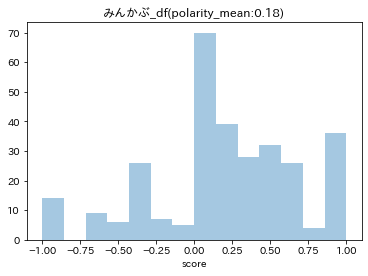

In [518]:
import japanize_matplotlib
line_plot = sns.lineplot()
figure = line_plot.get_figure()

plt.title('みんかぶ_df'+'('+'polarity_mean:'+str(a)+')',loc='center')
sns.distplot(df['score'],kde=False)

#figure.savefig('Desktop/みんかぶ_df.pdf')

In [519]:
df.loc[df['score'] >= 0,'polarity_flag'] = 1
df.loc[df['score'] <= 0,'polarity_flag'] = 0

In [520]:
df.head(3)

,coment,value,polarity,mecab_text,make_text,score,polarity_flag
0,スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっておりま...,5,1,スマホ 非常 操作 いる 多い それ 手数料 非常 総合 ランキング トップ 納得 若い 年...,スマホ 非常 操作 いる 多い それ 手数料 総合 ランキング トップ 納得 若い 年配 やすい,0.000000,0
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 手数料 高い 友人,手数料 ありがたい データ 優待 配当 情報 明確 今後 計画 毎日 高い 友人,0.600000,1
2,私の保有口座の中では総合的に一番活躍しています保有株式の売却額が直後に買い付け余力に反映され...,5,1,保有 口座 総合 一番 活躍 保有 株式 売却 直後 買い付け 余力 反映 取引 タイミング...,保有 口座 総合 一番 活躍 株式 売却 直後 買い付け 余力 反映 取引 タイミング ログ...,0.555556,1


In [521]:
df['polarity_flag'] = df['polarity_flag'].round().astype(int)

In [522]:
posi = []
litle_posi = []
litle_nega = []
nega = []
neutral = []

for l in df['score']:
    if 0.5 <= l <= 1:
        posi.append(l)
    elif 0 < l <= 0.5:
        litle_posi.append(l)
    elif -0.5 <= l < 0:
        litle_nega.append(l)
    elif -1 <= l < -0.5:
        nega.append(l)
    else:
        neutral.append(l)

Text(0.5, 1.0, 'みんかぶ_plot')

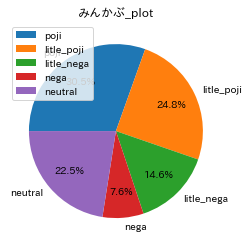

In [523]:
aa = len(posi)
bb = len(litle_posi)
cc = len(litle_nega)
dd = len(nega)
ee = len(neutral)
    
x = [aa,bb,cc,dd,ee]
label = ['poji','litle_poji','litle_nega','nega','neutral']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
    
plt.pie(x, labels=label, counterclock=False, startangle=180, autopct="%1.1f%%",pctdistance=0.7)

# legend and title
ax.legend(loc='best')
ax.set_title('みんかぶ_plot')


#fig.savefig("Desktop/みんかぶグラフ.pdf")

In [501]:
h = {'5':56,'4':159,'3':26,'2':16,'1':45}

In [510]:
pn = h['5'] + h['4'] + h['3'] + h['2'] + h['1']
popo = h['5'] + h['4'] + h['3']
nene = h['2'] + h['1']

In [513]:
popo/pn,nene/pn

(0.7980132450331126, 0.20198675496688742)

In [ ]:
#レビュー割合
３~５点　0.798(約８割)
１~２点　0.201(約２割)

In [ ]:
　#プロットの割合
posi+litle_posi+neutral 77.8%(約８割)
nega+litle_nega 22.2%(約２割)

In [494]:
p = df['polarity']
w = df['polarity_flag']

In [505]:
collections.Counter(p)

Counter({1: 241, 0: 61})

In [506]:
collections.Counter(w)

Counter({0: 135, 1: 167})

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [77]:
print('AUC in validation data: ', roc_auc_score(p, w))

AUC in validation data:  0.6966192776001632


In [78]:
confusion_matrix(p, w)

array([[ 25,  36],
       [  4, 237]])

In [79]:
accuracy = accuracy_score(p, w)
print('正解率:',accuracy)

正解率: 0.8675496688741722


In [80]:
recall = recall_score(p,w)
print('検出率:',recall)

検出率: 0.983402489626556


In [81]:
f1_score = f1_score(p,w)
print('f1_score:',f1_score)

f1_score: 0.9221789883268482


In [ ]:
#みんから
print('みんカラ')
print('AUC : 0.683')
print('混同行列 : [151,90],[16,45]')
print('正解率 : (0.65)','検出率 : (0.63)','F1 : (0.74)')

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [45]:
#データをランダムにシャッフル
df_s = df.sample(frac=1)

In [100]:
df_s.head(2)

,coment,value,polarity,mecab_text,make_text,wakachi
125,手数料も安く情報量もそれなりの量があるので助かっているが画面が非常に醜いのが難点 どこに何が...,4,1,手数料 情報 それなり ある いる 画面 非常 醜い 難点 どこ ある にくい 米国 手数料...,手数料 情報 それなり ある いる 画面 非常 醜い 難点 どこ にくい 米国 取扱 銘柄 ...,"[手数料, 情報, それなり, ある, いる, 画面, 非常, 醜い, 難点, どこ, にく..."
274,初めての登録で確認ごとが有りサポートセンターに電話を2020年4月28日の昼間にかけましたが...,1,0,登録 確認 ごと サポート センター 電話 2020 28 昼間 そこ 女性 オペレーション...,登録 確認 ごと サポート センター 電話 2020 28 昼間 そこ 女性 オペレーション...,"[登録, 確認, ごと, サポート, センター, 電話, 2020, 28, 昼間, そこ,..."


In [101]:
#7割
train = df_s[:int(len(df_s) * 0.7)]
#3割
test = df_s[int(len(df_s) * 0.7):]

In [102]:
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_train = vectorizer.fit_transform(train['make_text'])
tfidf_test = vectorizer.transform(test['make_text'])
vocabulary = vectorizer.get_feature_names()

In [103]:
X_train, X_val, y_train, y_val = train_test_split(
    tfidf_train, train["polarity"], test_size=0.3, random_state=1234)

In [104]:
params = {'n_estimators': [50, 100, 500], 'max_depth': [5, 10, 50]}

rf_tfidf = RandomForestClassifier(n_jobs=-1, random_state=1234)
gscv = GridSearchCV(rf_tfidf, param_grid=params, verbose=1, cv=3, scoring='roc_auc')
gscv.fit(X_train,y_train)
print(gscv.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'max_depth': 5, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   16.8s finished


In [114]:
rf_tfidf = RandomForestClassifier(
    n_jobs=-1, 
    random_state=1234,
    n_estimators=gscv.best_params_['n_estimators'],
    max_depth=gscv.best_params_['max_depth']
)
rf_tfidf.fit(X_train, y_train)
y_val_pred = rf_tfidf.predict_proba(X_val)

In [115]:
print('AUC in validation data: ', roc_auc_score(y_val, y_val_pred[:,1]))

AUC in validation data:  0.7546296296296298


In [107]:
train_sentence = [token.split(" ") for token in train["make_text"]]
test_sentence = [token.split(" ") for token in test['make_text']]

In [108]:
# skip-gramモデルの学習
skipgram_model = word2vec.Word2Vec(train_sentence,
                                                                       sg=1, 
                                                                       size=250,
                                                                       min_count=10,
                                                                       window=15, seed=1234)

In [109]:
"""
1. 抽出された各単語を、作成したword2Vecによってベクトル化
2. 変換された各単語ベクトルの平均をとり、その結果得られたベクトルを記事のベクトルとする
上記2ステップを実行する関数を作成
"""

num_features = 250

def avg_document_vector(data, num_features):
    document_vec = np.zeros((len(data), num_features))
    for i, doc_word_list in enumerate(data):
        feature_vec = np.zeros((num_features,), dtype="float32")
        for word in doc_word_list:
            try:
                feature_vec = np.add(feature_vec, skipgram_model.wv.__getitem__(word))
            except:
                pass

        feature_vec = np.divide(feature_vec, len(doc_word_list))
        document_vec[i] = feature_vec
    return document_vec

In [110]:
w2v_train = avg_document_vector(data=train_sentence, num_features=250)
w2v_test = avg_document_vector(data=test_sentence, num_features=250)

In [111]:
X_train, X_val, y_train, y_val = train_test_split(
    w2v_train, train["polarity"], test_size=0.3, random_state=1234)

In [113]:
clf_w2v = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1234)
clf_w2v.fit(X_train, y_train)

y_val_pred = clf_w2v.predict_proba(X_val)
print('AUC in validation data: ', roc_auc_score(y_val, y_val_pred[:,1]))

AUC in validation data:  0.7472222222222222


In [49]:
dict_list

[[{'positive': ['トップ', '若い'], 'negative': ['非常', '手数料'], 'score': 0.0}],
 [{'positive': ['配当', '情報', '明確', '友人'], 'negative': ['手数料'], 'score': 0.6}],
 [{'positive': ['一番', '活躍', '関心', 'おすすめ', 'ため', '有効', '情報'],
   'negative': ['取引', '煩わしい'],
   'score': 0.5555555555555556}],
 [{'positive': ['丁寧', '有り難い', 'サービス', '魅力', '満足'],
   'negative': ['取引', '不安', '手数料'],
   'score': 0.25}],
 [{'positive': ['信用', '満足', '為替', '簡単', '魅力'],
   'negative': ['取引', '金額', '手数料'],
   'score': 0.25}],
 [{'positive': ['無料', '資金'], 'negative': ['取引', '手数料'], 'score': 0.0}],
 [{'positive': ['老舗', '便利', '機能'],
   'negative': ['手数料', '安定-NEGATION'],
   'score': 0.2}],
 [{'positive': ['わかりやすさ', 'ダントツ', 'おすすめ', '為替'],
   'negative': ['手数料'],
   'score': 0.6}],
 [{'positive': ['期待', '面白い'],
   'negative': ['ポイント-NEGATION'],
   'score': 0.3333333333333333}],
 [{'positive': ['人気', '安心'],
   'negative': ['手数料'],
   'score': 0.3333333333333333}],
 [{'positive': ['いい', '豊富', '魅力'], 'negative': ['取引', '手数料'], 'score': 

In [103]:
posi_word = []
nega_word = []
sco = []

for i in dict_list:
    for c in i:
        posi_word.append(c['positive'])
        nega_word.append(c['negative'])
        sco.append(c['score'])

In [105]:
data = pd.DataFrame(columns=['ポジワード','ネガワード','スコア'])
data_new = data.assign(ポジワード=posi_word,ネガワード=nega_word,スコア=sco)

In [129]:
data_new = data_new.reset_index()

In [130]:
new = new.reset_index()

In [108]:
coment = df['coment']

In [110]:
data = pd.DataFrame(columns=['コメント'])
new = data.assign(コメント=coment)

In [134]:
dt = pd.merge(new,data_new,on='index',how='outer')

In [136]:
dt.head()

,index,コメント,ポジワード,ネガワード,スコア
0,0,スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっておりま...,"[トップ, 若い]","[非常, 手数料]",0.000000
1,1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,"[配当, 情報, 明確, 友人]",[手数料],0.600000
2,2,私の保有口座の中では総合的に一番活躍しています保有株式の売却額が直後に買い付け余力に反映され...,"[一番, 活躍, 関心, おすすめ, ため, 有効, 情報]","[取引, 煩わしい]",0.555556
3,3,株取引ってどんな物かと少し不安もありましたがなにしろ電話の対応が素晴らしく丁寧で初心者の私に...,"[丁寧, 有り難い, サービス, 魅力, 満足]","[取引, 不安, 手数料]",0.250000
4,4,信用取引をメインに考え口座開設しました約定金額が300万円超の場合手数料が0円ですし取引金利...,"[信用, 満足, 為替, 簡単, 魅力]","[取引, 金額, 手数料]",0.250000


In [158]:
import re
color_dic = {'yellow':'\033[43m', 'red':'\033[31m', 'blue':'\033[34m', 'end':'\033[0m'}

In [247]:
p = dt['ポジワード'][:30]
n = dt['ネガワード'][:30]
c = dt['コメント'][:30]

In [248]:
def print_texts(texts,posi_word,nega_word):
    for text in texts:
        for posi_key in posi_word:
            for posi_kw in posi_key:
                bef_posi = posi_kw
                aft_p = color_dic['yellow'] + posi_kw + color_dic['end']
                text = re.sub(bef_posi,aft_p,text)
                for nega_key in nega_word:
                    for nega_kw in nega_key:
                        bef_nega = nega_kw
                        aft_n = color_dic['blue'] + nega_kw + color_dic['end']
                        text = re.sub(bef_nega,aft_n,text)
        print(text)

In [249]:
print_texts(c,p,n)

スマホは非常に操作しやすく取り扱っている株が多いですそれに手数料も非常に安くて助かっております総合ランキングがトップなのが使っていたら納得できます若い方から年配の方まで使いやすいと思います 
手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後の計画立てやすく毎日楽しんでます 手数料が高いと言ってた友人に勧めました


私の保有口座の中では総合的に一番活躍しています保有株式の売却額が直後に買い付け余力に反映されますので取引タイミングを逃しませんログイン後のマイページには広告リンクや関心の持てないおすすめリンクが煩わしいですが重要なリンク先も多くあるためページ構成に慣れれば有効な情報源になりポートフォリオの管理も分かりやすいです
株取引ってどんな物かと少し不安もありましたがなにしろ電話の対応が素晴らしく丁寧で初心者の私には有り難いです色々なサービスがありやはり手数料が安いのは魅力ですPC画面的にも見やすいのは初老の私には満足です


信用取引をメインに考え口座開設しました約定金額が300万円超の場合手数料が0円ですし取引金利貸株料も他社よりも優れているので満足してます 為替が動いたときに簡単にFXの口座への振り替えが出来すぐにエントリーが出来点も魅力を感じてます


10万円以下の取引手数料も無料になり少額取引もやりやすくなりました前日取引が1回あればHYPER SBIも34日無料で使用できます資金を入金引出もセブンイレブンのATMで出来さらに朝7時夜19時まで手数料無料それに土日祝日も同様に行えます
扱っている商品も多く手数料も安い老舗の安定感があるネット専業銀行とのシームレスな連携など他社にはない便利な機能が多くSBIにまとめていますこれからも使い続けていきたいと思います


手数料はどこのネット証券も横並びになりつつありますがサイトのわかりやすさ使いやすさはダントツでSBI証券です特にこれから外国株式を始めたい方におすすめです住信SBIネット銀行の口座を開設すれば為替手数料も最安です意外と初心者の方は気にしないわからないですがこの手数料がボディブローのようにきいてきます
IPOではチャレンジポイントという他社にはないポイントがたまり外れてもいつかは当たるという期待を持ち続けることができるので面白いとおもいますまだ始めてから間もないのですがホームページも見やすく使いやすいと感じました
ネット証券として人気もあり安心感がもてるまた銀行との連携がよくいくつかの口座振り込みの中心口座に活用しているその理由は振込手数料が規定回数までかからない上低金利だが他の銀行より利率がよいことである


何気なく開設した証券口座ネットのレビューなどを参考にSBI証券に決めた取引時の操作などもわかりやすく手数料も安いので初心者には入門としていいのではと思う商品取扱数も豊富で投資の勉強になりますあとIPOの取扱が多くて魅力的
初めて証券会社に口座を作る際ネットで3社同時に口座開設の手続きをしましたがSBI証券の対応が早く1番早く開設できましたまだ開設したばかりなので今後 どこの証券会社がいいのか見ていきたいと思っております
最近取引をしていないし他の口座も所有していないので比較はできないが開設した時点では手数料が最も安かったと記憶している自身で情報を取得して取引する人に最適


格安取引をしようと探しましたがこの証券会社の総合力が上回る気がしますここ何年間の予測でもう少し株が下がる事を予測している会社が多い中オリンピックぐらいまでは上昇ムードが続くと私は思っていますその過程の中で急上昇しそうな物を見る目が有るのではと思うのがこの証券会社さんです
株主優待検索が使いやすいです株主優待目的で株購入をしているので何度も利用しています手数料が安いのも魅力ですクロス取引の利用方法も分かりやすく解説したサイトもあるので利用させてもらっています
PTS夜間取引があるので日中に売買しづらい会社員には大きなメリットですスクリーニングツールは3種類の設定で瞬時にリストがピックアップされるので便利ですIPOに応募して外れるとIPOチャレンジポイントが溜まっていくのでいずれはA級S級のIPOをゲットできる機会が得られるのは大きなメリットだと思います


手数料が安いのが魅力初心者でも使いやすく証券以外の投資方法も充実している新規公開株に申し込むチャンスもおおくIPOのチャレンジポイントを集めれば当選確率も大きく上がるまずはお試しという方にはちょうど良いのではないでしょうか
アプリを使うようになったがスマホで板を見るとき背景が黒なので電池の消耗が少なくなったが板をみてるときに上下に動かそうとすると取引画面になるので時々面倒また板の気配値を見てるときに現在値段と気配値が一緒に見れず画面を上下に動かすのも面倒だがこれらの原因は私がスマホ取引に慣れていないせいだと思う
分からない事が多い中で分かりやすくなっているので初心者にも優しいネットで手続きが出来るし同じ会社の銀行口座住信SBIネット銀行があれば振り込み不要で入金出来る小口も購入出来るし積立も便利私が証券初心者だからかもしれないが証券会社はSBI証券の証券口座しか開設していないけれど不満もないし改善してほしいなどの要望もない
30代で初めてネット証券に口座を作りましたが非常に使い勝手がよくて満足していますネット銀行も口座を持っていなかったのでついでにSBIを開設しました銀行と口座の相性の良さもいい


初心者に興味がある知りたい情報がたくさんのっているイメージがありますまた直感的で使いやすいです見たい情報の場所にすぐ行けて手続きなども迷わずできますある条件下にはなりますがツールで全版がみれるのも重宝しています
NISA口座で使用しています長い期間を設定しての注文が可能なため目標株価を決めて待伏せ注文をしていますまたネット証券口座数1位らしいのでシステムなども安心感があります住信SBI銀行でのハイブリッド預金ができるので資金移動が楽です
SBI証券は住信銀行のハイブリッド預金との連携が凄く便利ですコンビニATMの入金が無料だしハイブリッド預金に入れたら直ぐに買付余力に反映されるとにかく言いたい事は手軽に株とか色々買える所が5点の理由かな
携帯用アプリが使いやすかったので楽天証券でスタートしましたがその後手数料の安さ銘柄の多さ会社の信頼性でSBI証券に鞍替えしました株式投資以外にFXと金の積立と宝くじBIGもSBIにまとめてるので資金管理が非常に楽です
初心者でも利用しやすく分かりやすい証券口座です取り扱っている金融商品も充実していてIPOの取り引きにも有利だと思いますSBIネット銀行と連携して利用するとお金の移動もスマートに行えます
株価の推移グラフを1日2日3日5日10日1カ月2カ月3カ月6カ月1年間で瞬時に見られてその期間の株価の底とトップが表示されるので売買の予約にとても役にたちます


証券口座を開設して半年信用取引FX及び先物などを取引しているがアプリ等は非常に使いやすいIPOチャレンジポイントがたまるシステムはよいと思うチャレンジポイントを使えば当選確率はあがるためほしい銘柄を購入するチャンスが誰にでもあるまたリアルタイムにニュース等が配信されるため購入銘柄を探すのに便利である
手数料も安いです取引可能銘柄も多いです一部時間外取引も出来ます誰でもここに口座を持っていても損はないと思いますまたチャートも見やすく便利でおすすめです


投資初心者で日々勉強中です最初の証券口座としては十分すぎる情報と機能があります国内株式取引用のスマホアプリSBI証券 株は初心者でも直感的に使う事ができましたおすすめです
投資を始めたサイトだからというのもあるのかもしれないがサイトが使いやすいし手数料や取り扱いサービス数も充実しているまたPTS取引ができるというのが強みであり手数料も安くすむ


### BERTモデル

In [3]:
import torch
from pyknp import Juman
from pytorch_transformers import BertTokenizer, BertModel,BertConfig
from pytorch_transformers import BertForMaskedLM

In [4]:
config = BertConfig.from_json_file('/Users/nagasawanaokazu/Desktop/Japanese_L-12_H-768_A-12_E-30_BPE/bert_config.json')

model = BertForMaskedLM.from_pretrained('/Users/nagasawanaokazu/Desktop/Japanese_L-12_H-768_A-12_E-30_BPE/pytorch_model.bin', config=config)
bert_tokenizer = BertTokenizer('/Users/nagasawanaokazu/Desktop/Japanese_L-12_H-768_A-12_E-30_BPE/vocab.txt',
 do_lower_case=False, do_basic_tokenize=False)

In [5]:
text = "自然言語処理の＊について勉強中です。"
juman = Juman()
result = juman.analysis(text)
tokenized_text = [mrph.midasi for mrph in result.mrph_list()]
print(tokenized_text)

['自然', '言語', '処理', 'の', '＊', 'に', 'ついて', '勉強', '中', 'です', '。']


### 文章の区切れやマスクする部分をBERTに明示的に知らせるために、SEPやMASKを挿入していきます。

CLSは文章の頭に、SEPは文章の区切れに、MASKは隠したい部分に適用します。

In [5]:
tokenized_text.insert(0, '[CLS]')
tokenized_text.append('[SEP]')
masked_index = 5
tokenized_text[masked_index] = '[MASK]'
print(tokenized_text)

['[CLS]', '自然', '言語', '処理', 'の', '[MASK]', 'に', 'ついて', '勉強', '中', 'です', '。', '[SEP]']


In [51]:
tokens = bert_tokenizer.convert_tokens_to_ids(tokenized_text)
tokens_tensor = torch.tensor([tokens])

In [52]:
model.eval()
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]
_,predicted_indexes = torch.topk(predictions[0, masked_index], k=10)
predicted_tokens = bert_tokenizer.convert_ids_to_tokens(predicted_indexes.tolist())
print(predicted_tokens)

['基礎', '方法', '仕組み', '応用', '技術', '技法', 'アルゴリズム', '問題', '知識', '基本']


In [13]:
#oseti_model
print('oseti_model')
print('AUC : 0.604')
print('混同行列 : [1,3],[4,92]')
print('正解率 : (0.93)','検出率 : (0.96)','F1 : (0.96)')

oseti_model
AUC : 0.604
混同行列 : [1,3],[4,92]
正解率 : (0.93) 検出率 : (0.96) F1 : (0.96)


In [16]:
#my_model
print('my_model')
print('AUC : 0.286')

my_model
AUC : 0.286


In [14]:
#chabsa_model_2
print('chabsa_model_2')
print('AUC : 0.5')
print('混同行列 : [0,10],[0,90]')
print('正解率 : (0.90)','検出率 : (1.0)','F1 : (0.947)')

chabsa_model_2
AUC : 0.5
混同行列 : [0,10],[0,90]
正解率 : (0.90) 検出率 : (1.0) F1 : (0.947)


In [15]:
#chabsa_model
print('chabsa_model')
print('AUC : 0.841')
print('正解率 : (0.846)','検出率 : (0.867)','F1 : (0.870)')

chabsa_model
AUC : 0.841
正解率 : (0.846) 検出率 : (0.867) F1 : (0.870)


In [14]:
%%capture capt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("daigo/bert-base-japanese-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("daigo/bert-base-japanese-sentiment")

In [15]:
# シンプルな動作確認
print(pipeline("sentiment-analysis",model="daigo/bert-base-japanese-sentiment",tokenizer="daigo/bert-base-japanese-sentiment")("私は幸福である。"))

[{'label': 'ポジティブ', 'score': 0.9843042492866516}]


In [16]:
text = [
             'この人は、この世の中で、いちばんしあわせな人にちがいありません。',
             '芝居小屋もすばらしいし、お客さんもすばらしい人たちでした。',
             'もし中世の時代だったら、おそらく、火あぶりにされたでしょうよ。',
             'みんなのうるさいことといったら、まるで、ハエがびんの中で、ブンブンいっているようでした。',
             'われわれ人間が、こういうことを考えだすことができるとすれば、われわれは、地の中にうめられるまでに、もっと長生きできてもいいはずだが'
]

In [17]:
sentiment_analyzer = pipeline("sentiment-analysis",model="daigo/bert-base-japanese-sentiment",tokenizer="daigo/bert-base-japanese-sentiment")
list(map(sentiment_analyzer, text))

[[{'label': 'ポジティブ', 'score': 0.6794147491455078}],
 [{'label': 'ポジティブ', 'score': 0.972648024559021}],
 [{'label': 'ポジティブ', 'score': 0.8007590174674988}],
 [{'label': 'ポジティブ', 'score': 0.7873092889785767}],
 [{'label': 'ポジティブ', 'score': 0.9143434166908264}]]

In [62]:
df.head()

,coment,value,polarity
0,スマホは非常に操作しやすく、取り扱っている株が多いです。それに手数料も非常に安くて助かってお...,5,1
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1
2,私の保有口座の中では総合的に一番活躍しています。保有株式の売却額が、直後に買い付け余力に反映...,5,1
3,株取引ってどんな物かと少し不安もありましたが、なにしろ電話の対応が素晴らしく、丁寧で、初心者...,5,1
4,信用取引をメインに考え口座開設しました。約定金額が300万円超の場合、手数料が0円ですし、取...,5,1


In [65]:
texts = []

for i in df['coment']:
    #空白削除
    col = i.replace('\u3000','')
    texts.append(col)

In [66]:
tes = list(map(sentiment_analyzer, texts))

In [39]:
for (i,j) in zip(texts[295:],tes[295:]):
        print(i)
        print(j)
        print('**************************************************************')

全く使えない最悪な証券会社                                                                                                                                                                       
[{'label': 'ネガティブ', 'score': 0.9836410284042358}]
**************************************************************
PTS取引が反映されず翌日の通常取引と二重取引が発生しました出金支持後口座はマイナス表示となりコールセンターに問い合わせたところ入金手数料は契約者負担でお願いしますとのこと取引内容の説明もこちらからの電話で行うことや対応期間の短かさなど信頼性にかけますトラブル時は覚悟して初期契約したほうがよいです
[{'label': 'ポジティブ', 'score': 0.8202364444732666}]
**************************************************************
7月12日にPTS夜間取引で株を購入7月17日株が値上がりしたので売り注文だしたらシステム障害で現物売り注文できずその日のうちに株価5急落翌日4下落SBI証券100責任私の責任ゼロカスタマーセンターに連絡したら謝罪するだけで口座開設時にシステム障害で損失しても責任なしと書いてありますと説明されておわり怒りが収まりません
[{'label': 'ポジティブ', 'score': 0.6016407608985901}]
**************************************************************
とにかくスクリーナの性能が悪い特に外国株が悪いほんとにいい株を見逃しているそれどころか実体のない項目も上げている項目についてスクリーナのこの項目はどこで見ればいいのかと質問するとご要望には対応していませんと返答がくる実体をそなえていないようならのせるなよといいたいところですとにかくこの会社のスクリーナは信用できません
[{'label'

In [67]:
labeling = []

for col in tes:
    for dist in col:
        if dist['label'] == 'ポジティブ':
            labeling.append(1)
        elif dist['label'] == 'ネガティブ':
            labeling.append(0)

In [68]:
df['bert_label'] = labeling

In [69]:
df.head(3)

,coment,value,polarity,bert_label
0,スマホは非常に操作しやすく、取り扱っている株が多いです。それに手数料も非常に安くて助かってお...,5,1,1
1,手数料がいらないから本当にありがたいし データも分かりやすく 優待 配当情報も明確なので今後...,5,1,1
2,私の保有口座の中では総合的に一番活躍しています。保有株式の売却額が、直後に買い付け余力に反映...,5,1,1


In [70]:
p = df['polarity']
w = df['bert_label']

In [71]:
print('AUC in validation data: ', roc_auc_score(p, w))

AUC in validation data:  0.6966192776001632


In [258]:
model = AutoModelForSequenceClassification.from_pretrained('daigo/bert-base-japanese-sentiment') 
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer)
print(nlp("私は幸せである。"))

[{'label': 'ポジティブ', 'score': 0.9903476238250732}]


In [267]:
print(nlp(df['coment'][298]))

[{'label': 'ネガティブ', 'score': 0.6882160305976868}]


In [273]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# トークナイザーとモデルの準備
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [278]:
# テキスト
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
# 質問
questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]

In [276]:
text = r"""
🤗 Transformers(旧称：pytorch-transformers、pytorch-pretrained-bert)は、
自然言語理解（NLU）と自然言語生成（NLG）のための汎用アーキテクチャ
（BERT、GPT-2、RoBERTa、XLM、DistilBert、XLNet...）を100以上の言語で
32以上の事前学習モデルと
TensorFlow 2.0とPyTorchの間の相互運用性を提供します。
"""
questions = [
    'Transformersには何種類の事前学習モデルがあるのか？',
    'Transformersは何を提供しているのか？',
    'Transformersはどのフレームワーク間の相互運用性を提供していますか？'
]

In [279]:
for question in questions:
    # 前処理
    inputs = tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    # 推論
    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_start_scores, answer_end_scores = model(**inputs)

    # 可能性の高い回答の取得
    answer_start = torch.argmax(answer_start_scores)  
    answer_end = torch.argmax(answer_end_scores) + 1 
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    # 出力
    print(f"Question: {question}")
    print(f"Answer: {answer}\n")

Question: How many pretrained models are available in Transformers?
Answer: over 32 +

Question: What does Transformers provide?
Answer: general - purpose architectures

Question: Transformers provides interoperability between which frameworks?
Answer: tensorflow 2 . 0 and pytorch

